In [1]:
from pprint import PrettyPrinter
pp = PrettyPrinter(compact=True, indent=4, depth=3)
from functools import partial
import json
from collections import defaultdict
from operator import itemgetter
from pathlib import Path
import pandas as pd
import torch
import numpy as np
from tdigest import TDigest

%matplotlib inline
import matplotlib.pyplot as plt; plt.style.use('bmh')
import matplotlib as mpl
from importlib import reload
import src.conformal  as cp
import src.temperature as ts
import src.helpers as helpers
reload(helpers)
reload(cp)
reload(ts)
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']

In [2]:
fst, snd = map(itemgetter, range(2))

In [3]:
fig_dir = Path('figures')
fig_dir.mkdir(exist_ok=True)

path_to_experiments = Path('new_experiments/')
# path_to_experiments = Path('experiments/')

In [26]:
reload(helpers)
dataset = 'cifar10'

clients_class_map = helpers.get_client_map(dataset)
num_classes = sum(map(len, clients_class_map.values()))
# model = 'cnn'
model = 'small_resnet14'
cifar1_experiments = {
    'fedavg': helpers.load_scores(*path_to_experiments.glob(f'cifar10_fedavg_{model}'), dataset=dataset),
}
cifar2_experiments = {
    'fedavg': helpers.load_scores(*path_to_experiments.glob(f'cifar10-2_fedavg_{model}'), dataset=dataset),
}
cifar3_experiments = {
    'fedavg': helpers.load_scores(*path_to_experiments.glob(f'cifar10-3_fedavg_{model}'), dataset=dataset),
}
cifar4_experiments = {
    'fedavg': helpers.load_scores(*path_to_experiments.glob(f'cifar10_fedavg_{model}_iid_partition'), dataset=dataset),
}

# cifar1_experiments = {
#     'tct': helpers.load_scores(*path_to_experiments.glob(f'cifar10_tct_{model}'), dataset=dataset),
# }
# cifar2_experiments = {
#     'tct': helpers.load_scores(*path_to_experiments.glob(f'cifar10-2_tct_{model}'), dataset=dataset),
# }
# cifar3_experiments = {
#     'tct': helpers.load_scores(*path_to_experiments.glob(f'cifar10-3_tct_{model}'), dataset=dataset),
# }
# cifar4_experiments = {
#     'tct': helpers.load_scores(*path_to_experiments.glob(f'cifar10_tct_{model}_iid_partition'), dataset=dataset),
# }
    

In [27]:
def accuracy(scores, targets):
    correct = scores.argmax(1) == targets
    # total = targets.size(0)
    total = targets.shape[0]
    return (correct.sum() / total).item()

In [28]:
reload(helpers)
cifar1_test_acc = defaultdict(list) 
cifar2_test_acc = defaultdict(list) 
cifar3_test_acc = defaultdict(list) 
cifar4_test_acc = defaultdict(list) 
for trial in range(100):
    trial1 = helpers.get_new_trial(cifar1_experiments)
    trial2 = helpers.get_new_trial(cifar2_experiments)
    trial3 = helpers.get_new_trial(cifar3_experiments)
    trial4 = helpers.get_new_trial(cifar4_experiments)
    
    for k, v in trial1['experiments'].items():
        cifar1_test_acc[k].append(accuracy(v['test_scores'], v['test_targets']))
    for k, v in trial2['experiments'].items():
        cifar2_test_acc[k].append(accuracy(v['test_scores'], v['test_targets']))
    for k, v in trial3['experiments'].items():
        cifar3_test_acc[k].append(accuracy(v['test_scores'], v['test_targets']))
    for k, v in trial4['experiments'].items():
        cifar4_test_acc[k].append(accuracy(v['test_scores'], v['test_targets']))

for k, v in cifar1_test_acc.items():
    print(f"\n{k.upper().center(20, '=')}")
    print('test\t', f'{np.mean(v):.2f}')
                                          
for k, v in cifar2_test_acc.items():
    print(f"\n{k.upper().center(20, '=')}")
    print('test\t', f'{np.mean(v):.2f}')
for k, v in cifar3_test_acc.items():
    print(f"\n{k.upper().center(20, '=')}")
    print('test\t', f'{np.mean(v):.2f}')
for k, v in cifar4_test_acc.items():
    print(f"\n{k.upper().center(20, '=')}")
    print('test\t', f'{np.mean(v):.2f}')


=======FEDAVG=======
test	 0.50

=======FEDAVG=======
test	 0.67

=======FEDAVG=======
test	 0.81

=======FEDAVG=======
test	 0.88


In [31]:
reload(cp)
reload(helpers)
reload(ts)
num_trials = 10

cifar1_trials = {}
cifar2_trials = {}
cifar3_trials = {}
cifar4_trials = {}
for i in range(num_trials):
    
    # randomly split into calibration and evaluation sets
    trial1 = helpers.get_new_trial(cifar1_experiments)['experiments']
    trial2 = helpers.get_new_trial(cifar2_experiments)['experiments']
    trial3 = helpers.get_new_trial(cifar3_experiments)['experiments']
    trial4 = helpers.get_new_trial(cifar4_experiments)['experiments']

    # apply aggregate temperature scaling
    ts.client_temp_scale(trial1, clients_class_map)
    ts.client_temp_scale(trial2, clients_class_map)
    ts.client_temp_scale(trial3, clients_class_map)
    ts.client_temp_scale(trial4, clients_class_map)
    
    client_index_map1 = {k: sum(trial1['fedavg']['val_targets'] == k for k in v).bool() for k, v in clients_class_map.items()}
    client_index_map2 = {k: sum(trial2['fedavg']['val_targets'] == k for k in v).bool() for k, v in clients_class_map.items()}
    client_index_map3 = {k: sum(trial3['fedavg']['val_targets'] == k for k in v).bool() for k, v in clients_class_map.items()}
    client_index_map4 = {k: sum(trial4['fedavg']['val_targets'] == k for k in v).bool() for k, v in clients_class_map.items()}
    # client_index_map1 = {k: sum(trial1['tct']['val_targets'] == k for k in v).bool() for k, v in clients_class_map.items()}
    # client_index_map2 = {k: sum(trial2['tct']['val_targets'] == k for k in v).bool() for k, v in clients_class_map.items()}
    # client_index_map3 = {k: sum(trial3['tct']['val_targets'] == k for k in v).bool() for k, v in clients_class_map.items()}
    # client_index_map4 = {k: sum(trial4['tct']['val_targets'] == k for k in v).bool() for k, v in clients_class_map.items()}

    # conformal parameters
    # alphas = np.arange(0.05, 1, 0.05)
    alphas = np.arange(0.10, 1, 0.10)
    alphas = list(map(lambda x: np.round(x, 2), alphas))
    allow_empty_sets = False # set to True for upper marginal bound
    # allow_empty_sets = True
    method = 'lac' # score function: naive, lac, aps, raps
    # method = 'aps' 
    # method = 'raps' 

    f = itemgetter('temp_val_scores', 'val_targets', 'temp_test_scores', 'test_targets')
    
    cifar1_trials[i] = cp.get_coverage_size_over_alphas(*f(trial1['fedavg']), method=method, allow_empty_sets=allow_empty_sets, alphas=alphas, decentral=True, client_index_map=client_index_map1)
    cifar2_trials[i] = cp.get_coverage_size_over_alphas(*f(trial2['fedavg']), method=method, allow_empty_sets=allow_empty_sets, alphas=alphas, decentral=True, client_index_map=client_index_map2)
    cifar3_trials[i] = cp.get_coverage_size_over_alphas(*f(trial3['fedavg']), method=method, allow_empty_sets=allow_empty_sets, alphas=alphas, decentral=True, client_index_map=client_index_map3)
    cifar4_trials[i] = cp.get_coverage_size_over_alphas(*f(trial4['fedavg']), method=method, allow_empty_sets=allow_empty_sets, alphas=alphas, decentral=True, client_index_map=client_index_map4)
    # cifar1_trials[i] = cp.get_coverage_size_over_alphas(*f(trial1['tct']), method=method, allow_empty_sets=allow_empty_sets, alphas=alphas, decentral=True, client_index_map=client_index_map1)
    # cifar2_trials[i] = cp.get_coverage_size_over_alphas(*f(trial2['tct']), method=method, allow_empty_sets=allow_empty_sets, alphas=alphas, decentral=True, client_index_map=client_index_map2)
    # cifar3_trials[i] = cp.get_coverage_size_over_alphas(*f(trial3['tct']), method=method, allow_empty_sets=allow_empty_sets, alphas=alphas, decentral=True, client_index_map=client_index_map3)
    # cifar4_trials[i] = cp.get_coverage_size_over_alphas(*f(trial4['tct']), method=method, allow_empty_sets=allow_empty_sets, alphas=alphas, decentral=True, client_index_map=client_index_map4)
    print(f'finished trial={i}')
    

finished trial=0
finished trial=1
finished trial=2
finished trial=3
finished trial=4
finished trial=5
finished trial=6
finished trial=7
finished trial=8
finished trial=9


In [32]:
reload(helpers)
cifar1_results = helpers.combine_trials(cifar1_trials)
cifar2_results = helpers.combine_trials(cifar2_trials)
cifar3_results = helpers.combine_trials(cifar3_trials)
cifar4_results = helpers.combine_trials(cifar4_trials)

In [33]:

n =4
interp_cmap = [round(x) for x in np.linspace(0, 255, n)]
interp_cmap
color = [mpl.colormaps['viridis'].colors[interp_cmap[k]] for k in range(n)]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


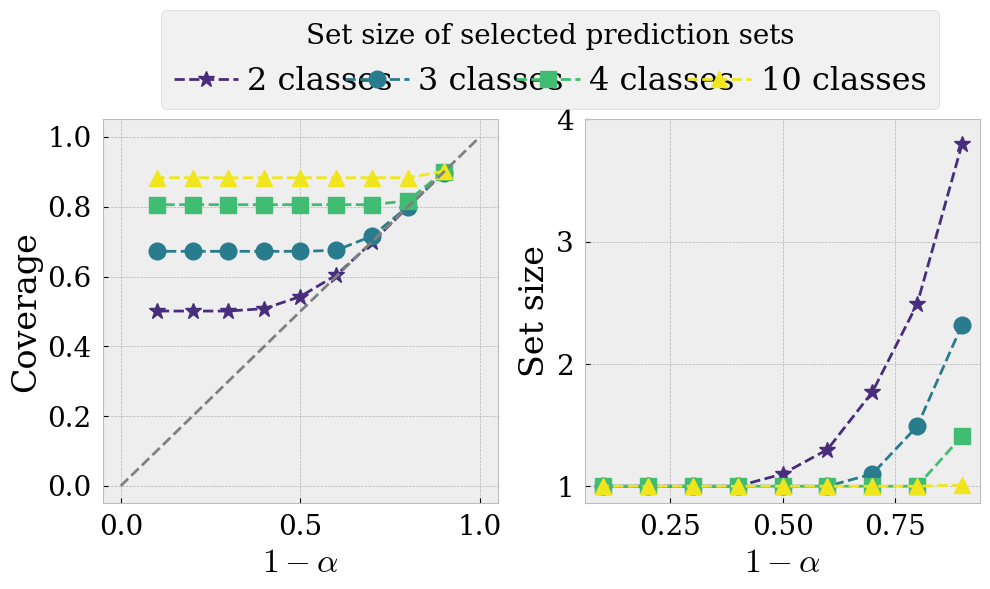

In [38]:
alphas = np.arange(0.10, 1, 0.10)
alphas = list(map(lambda x: np.round(x, 2), alphas))

# plotting settings
fontsize=24
style = '--'
markersize=12

exp_1 = cifar1_results['mean']
exp_2 = cifar2_results['mean']
exp_3 = cifar3_results['mean']
exp_4 = cifar4_results['mean']
exp_1_label = '2 classes'
exp_2_label = '3 classes'
exp_3_label = '4 classes'
exp_4_label = '10 classes'

n = 4
interp_cmap = [round(x) for x in np.linspace(32, 250, n)]
color = [mpl.colormaps['viridis'].colors[interp_cmap[k]] for k in range(n)]

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    
if exp_1 is not None:
    ax[0].plot(*zip(*exp_1['coverage'].items()), style, marker='*', label=exp_1_label, markersize=markersize, c=color[0])
    ax[1].plot(*zip(*exp_1['size'].items()), style, marker='*',  markersize=markersize, c=color[0])
    
if exp_2 is not None:
    ax[0].plot(*zip(*exp_2['coverage'].items()), style, marker='o', label=exp_2_label, markersize=markersize, c=color[1])
    ax[1].plot(*zip(*exp_2['size'].items()), style, marker='o',  markersize=markersize, c=color[1])
    
if exp_3 is not None:
    ax[0].plot(*zip(*exp_3['coverage'].items()), style, marker='s', label=exp_3_label, markersize=markersize, c=color[2])
    ax[1].plot(*zip(*exp_3['size'].items()), style, marker='s',  markersize=markersize, c=color[2])
    
if exp_4 is not None:
    ax[0].plot(*zip(*exp_4['coverage'].items()), style, marker='^', label=exp_4_label, markersize=markersize, c=color[3])
    ax[1].plot(*zip(*exp_4['size'].items()), style, marker='^',  markersize=markersize, c=color[3])
    


ax[0].plot([0, 1], [0, 1], '--', color='gray')

# ax[0].set_xlim(0.5, 1)
# ax[0].set_ylim(0.5, 1)
# ax[1].set_xlim(0.5, 1)
# ax[1].set_ylim(0.9, 1)
ax[0].set_xlabel(r'$1-\alpha$', fontsize=fontsize)
ax[1].set_xlabel(r'$1-\alpha$', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)
ax[1].set_ylabel('Set size', fontsize=fontsize)
# ax[0].set_xticks([ 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# ax[1].set_xticks([ 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax[1].set_yticks([1, 2, 3, 4])
ax[0].xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[0].yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[1].xaxis.set_tick_params(labelsize=fontsize-4, pad=8)
ax[1].yaxis.set_tick_params(labelsize=fontsize-4, pad=8)
# ax[0].legend(fancybox=False, fontsize=fontsize-6, loc='lower right', framealpha=1.0)
# ax[1].legend(fancybox=False, fontsize=fontsize-6, loc='upper left', framealpha=1.0)
fig.legend(ncol=4, fontsize=fontsize-1, 
          title='Set size of selected prediction sets', title_fontsize=fontsize-4, 
          bbox_to_anchor=(0.150, 0, 0.81, 1.25), fancybox = True, #shadow = True,
           mode="expand",
           handletextpad=0.3,
 )

plt.tight_layout()
plt.savefig(fig_dir / f'data-hetero-{dataset}-{method}-fedavg.eps', bbox_inches='tight')
plt.show()

In [ ]:
alphas = [0.9, 0.8, 0.7]
# alphas = [0.1, 0.2, 0.3]
allow_empty_sets = False
# allow_empty_sets = True
method = 'lac'
precision=3

for k, v in cifar1_results.items():
    print('\n', k.center(30, '='))
    for met, val in v.items():
        if met not in ('size', 'coverage'): continue
        print(met.center(20, '='))
        for a, b in val.items():
            if a in alphas:
                print(a, '\t', round(b, 2))

for k, v in cifar2_results.items():
    print('\n', k.center(30, '='))
    for met, val in v.items():
        if met not in ('size', 'coverage'): continue
        print(met.center(20, '='))
        for a, b in val.items():
            if a in alphas:
                print(a, '\t', round(b, 2))
                
for k, v in cifar3_results.items():
    print('\n', k.center(30, '='))
    for met, val in v.items():
        if met not in ('size', 'coverage'): continue
        print(met.center(20, '='))
        for a, b in val.items():
            if a in alphas:
                print(a, '\t', round(b, 2))


for k, v in cifar4_results.items():
    print('\n', k.center(30, '='))
    for met, val in v.items():
        if met not in ('size', 'coverage'): continue
        print(met.center(20, '='))
        for a, b in val.items():
            if a in alphas:
                print(a, '\t', round(b, 2))